# Example: Modeling surface brightness discontinuities #

This tutorial shows how to use PyProffit to model surface brightness discontinuities in galaxy clusters (shocks and cold fronts), in particular to determine the density compression factor. Here we take the example of _XMM-Newton_ observations of A2142 (z=0.09), which hosts one of the most famous cold fronts and the first to be recognized as such (Markevitch et al. 2000).

In [1]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt

We use the publicly available _XMM-Newton_ mosaic of A2142 extracted by the X-COP team and available [here](https://dominiqueeckert.wixsite.com/xcop/a2142). We start by loading the image, exposure map and background map into a [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) structure

In [2]:
dat = pyproffit.Data(imglink='/home/deckert/Documents/Work/cluster_data/VLP/a2142/mosaic_a2142.fits.gz',
                    explink='/home/deckert/Documents/Work/cluster_data/VLP/a2142/mosaic_a2142_expo.fits.gz',
                    bkglink='/home/deckert/Documents/Work/cluster_data/VLP/a2142/mosaic_a2142_bkg.fits.gz')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


Let's have a look at the data. Here it is a mosaics of several _XMM-Newton_ pointings:

<ipython-input-3-9eeab1757565>:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.flipud(np.log10(dat.img)),aspect='auto')


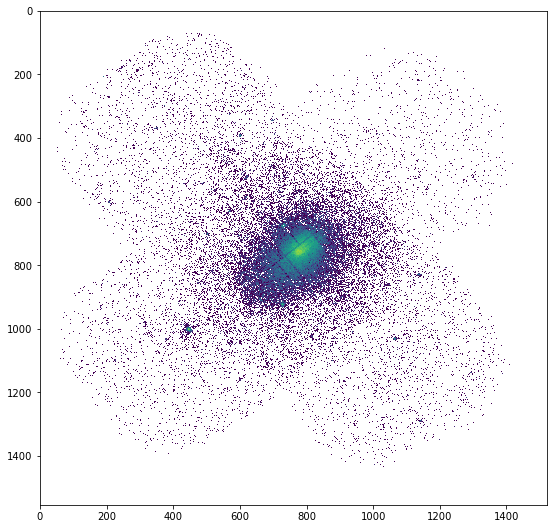

In [3]:
fig = plt.figure(figsize=(20,20))
s1=plt.subplot(221)
plt.imshow(np.flipud(np.log10(dat.img)),aspect='auto')


We mask the detected point sources to avoid contaminating the profile

In [4]:
dat.region('/home/deckert/Documents/Work/cluster_data/VLP/a2142/src_ps.reg')

Excluded 226 sources


The cold front is located about 3 arcmin North-West of the cluster core, i.e. in the top-right direction in the above plot. By inspecting the image with DS9 we need to get an idea of the geometry of the front, i.e. we need to define a sector across which the front will be sharpest. In this case the front is highly elliptical, with a position angle that is inclinated by ~40 degrees with respect to the Right Ascension axis.

We now define a [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) to which we pass the necessary information. We will extract a profile centered on R.A.= 239.5863, Dec=27.226989 with a linear binning of 5 arcsec width out to 10 arcmin

In [5]:
prof = pyproffit.Profile(data=dat, binsize=5., maxrad=10., 
                         center_choice='custom_fk5', center_ra=239.5863, center_dec=27.226989)

Corresponding pixels coordinates:  775.303810518434 791.9785944739778


Now we extract the profile using the [SBprofile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile.SBprofile) method of the [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) class. We select the data in a sector between position angles 10 and 70 degrees, across an ellipse rotated by 40 degrees and with a major-to-minor axis ratio of 1.65. Note that _PyProffit_ follows the DS9 convention, i.e. the zero point refers to the Right Ascension axis.

In [6]:
prof.SBprofile(rotation_angle=40., ellipse_ratio=1.65,
              angle_low=10., angle_high=70.)

<Figure size 432x288 with 0 Axes>

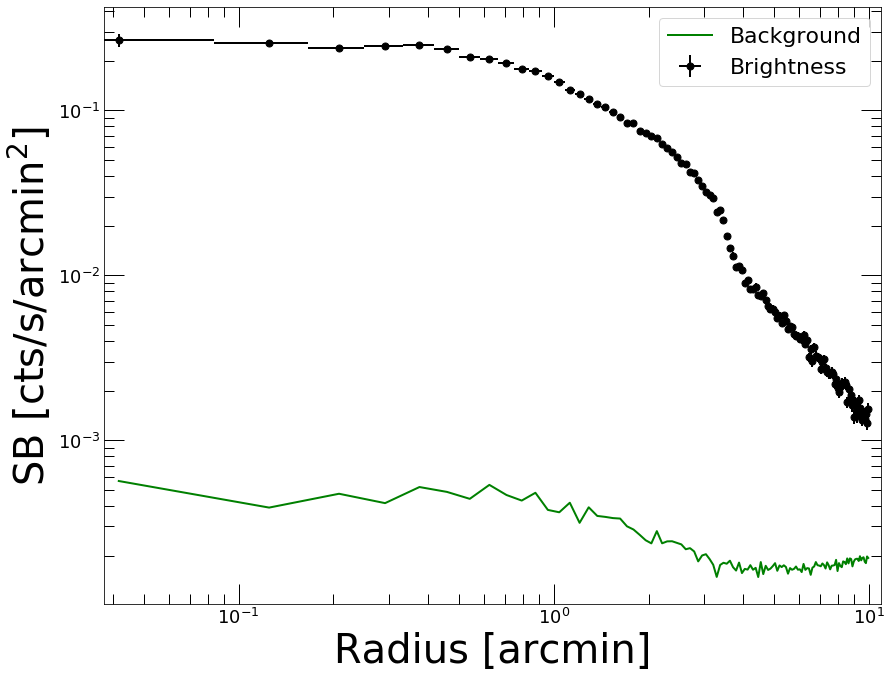

In [7]:
prof.Plot()

## Comparing sectors ##

The break in the profile between 3 and 4 arcmin is well visible. We can inspect it further by comparing the brightness across several sectors; this is done by defining other [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) objects and comparing them using the [plot_multi_profiles](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.plot_multi_profiles) function


In [8]:
prof_se = pyproffit.Profile(data=dat, binsize=5., maxrad=10., 
                         center_choice='custom_fk5', center_ra=239.5863, center_dec=27.226989)

prof_ne = pyproffit.Profile(data=dat, binsize=5., maxrad=10., 
                         center_choice='custom_fk5', center_ra=239.5863, center_dec=27.226989)

prof_sw = pyproffit.Profile(data=dat, binsize=5., maxrad=10., 
                         center_choice='custom_fk5', center_ra=239.5863, center_dec=27.226989)

Corresponding pixels coordinates:  775.303810518434 791.9785944739778
Corresponding pixels coordinates:  775.303810518434 791.9785944739778
Corresponding pixels coordinates:  775.303810518434 791.9785944739778


In the new [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) structures we now load brightness profiles in sectors of 60 degree opening along 4 perpendicular directions

In [9]:
prof_se.SBprofile(rotation_angle=40., ellipse_ratio=1.65,
              angle_low=190., angle_high=250.)

prof_ne.SBprofile(rotation_angle=40., ellipse_ratio=1.65,
              angle_low=100., angle_high=160.)

prof_sw.SBprofile(rotation_angle=40., ellipse_ratio=1.65, 
                 angle_low=280., angle_high=340.)

We can now display all 4 profiles together using the [plot_multi_profiles](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.plot_multi_profiles) function

Showing 4 brightness profiles


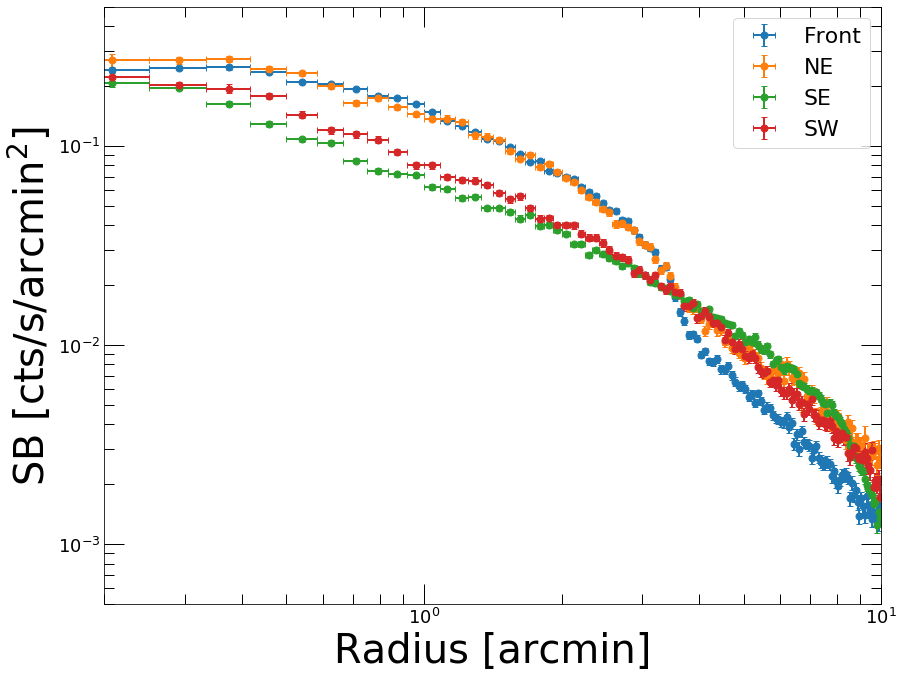

In [10]:
fig = pyproffit.plot_multi_profiles(profs=(prof, prof_ne, prof_se, prof_sw),
                             labels=('Front', 'NE', 'SE', 'SW'),
                             axes=[0.2, 10., 5e-4, 0.5])

We can see clearly the difference between the various sectors. The sectors on the South show no discontinuity around 3-4 arcmin. The front can be observed as well in the NE direction, although it is not as sharp as in the direction that we previously identified for the front.

To search for deviations from symmetry we can also look at the _azimuthal scatter_, i.e. the quantity

$$ \Sigma_{X}(r) = \left(\sum_{i=1}^N \frac{(S_i(r) - \langle S(r)\rangle)^2}{\langle S(r)\rangle^2} \right)^{1/2} $$

with $S_i(r)$ the surface brightness profile determined in $N$ individual sectors covering the azimuth from 0 to 360 degrees with an opening angle of $360/N$ degrees, and $\langle S(r)\rangle$ a loaded mean surface brightness profile

In [11]:
prof_tot = pyproffit.Profile(data=dat, binsize=20., maxrad=10., 
                         center_choice='custom_fk5', center_ra=239.5863, center_dec=27.226989)

prof_tot.SBprofile()

prof_tot.AzimuthalScatter(nsect=12)

Corresponding pixels coordinates:  775.303810518434 791.9785944739778


<Figure size 432x288 with 0 Axes>

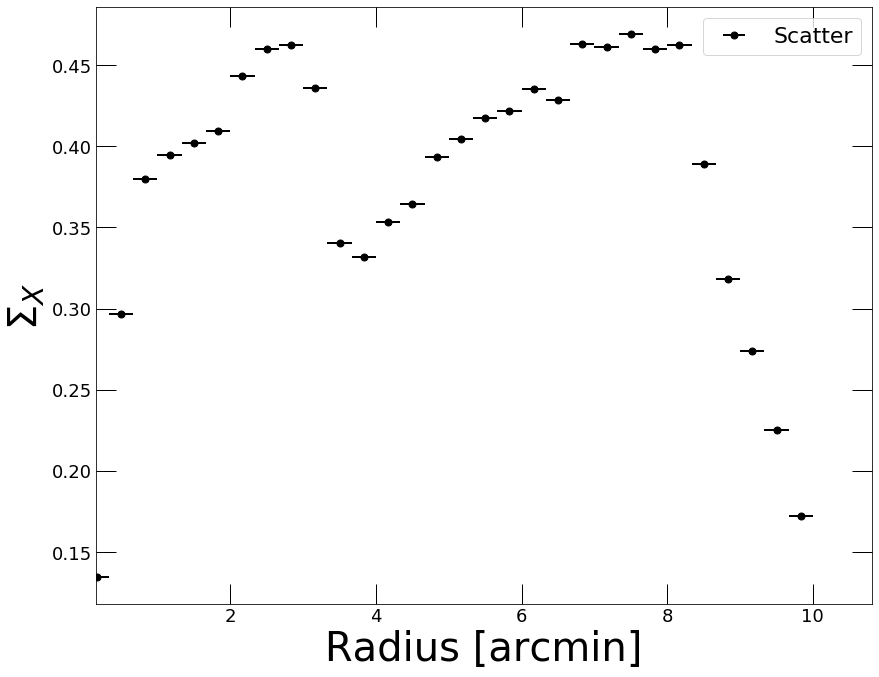

In [12]:
prof_tot.Plot(scatter=True, yscale='linear', xscale='linear')

The azimuthal scatter shows two regions of enhanced scatter followed by two sharp drops. The enhanced scatter is induced by sloshing gas extending out to the cold fronts; beyond the cold fronts the scatter from one sector to the other decreases sharply. This method can be useful to pinpoint the radii of the cold fronts.

## Modeling the brightness profile ##

Now that we are confident that we have identified the feature of interest, let's try to model it. First, we need to account for the _XMM-Newton_ PSF, which smears the gradient across the front and would lead to an underestimation of the compression factor. To this aim, we create a function describing the _XMM-Newton_ PSF as a function of distance, and we use the [PSF](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile.PSF) method to generate a PSF mixing matrix. We describe the _XMM-Newton_ PSF as a King function with parameters provided in the calibration files

In [13]:
# Function describing the PSF
def fking(x):
    r0=0.0883981 # core radius in arcmin
    alpha=1.58918 # outer slope
    return np.power(1.+(x/r0)**2,-alpha)

prof.PSF(psffunc=fking)


As is usually done in these cases, we assume that the 3D distribution is described as two power laws with an infinitely small discontinuity. The 3D broken power law is then projected onto the line of sight:

$$ I(r)=I_0 \int F(\omega)^2\, d\ell + B$$

with $\omega^2 = r^2 + \ell^2$ and

$$ F(\omega) = \left\{ \begin{array}{ll} \omega^{-\alpha_1}, & \omega<r_f \\ \frac{1}{C}\omega^{-\alpha_2}, & \omega \geq r_f \end{array} \right. $$

PyProffit includes the [BknPow](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.BknPow) function which implements this model. We now define a [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) object containing the appropriate model to describe the front

In [14]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


To choose appropriate starting points for the parameter, we can set up initial values and inspect how the model compares to the data

<Figure size 432x288 with 0 Axes>

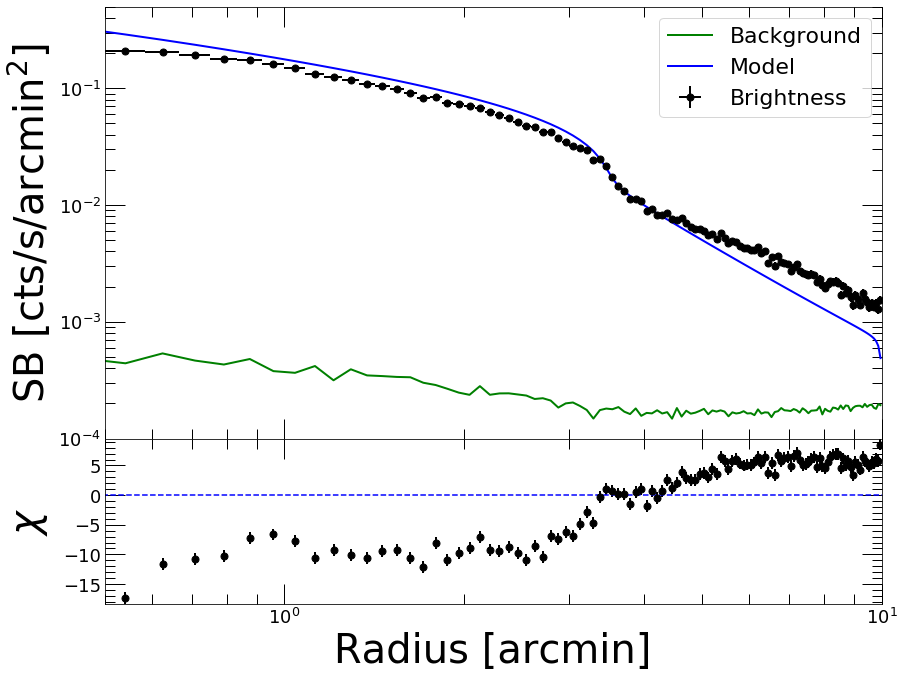

In [15]:
modbkn.SetParameters([0.8, 2., 3.5, -1.8, 1.8, -4.])

prof.Plot(model=modbkn, axes=[0.5, 10., 1e-4, 0.5])

We are now ready to optimize the model. To do this, we set up a [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) object and pass to it the data and the model. We run the optimization using the [Migrad](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter.Migrad) method of the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) class. 

To focus on the region surrounding the front, we fit the data between 1 and 7 arcmin such that we still have a good handle of the slopes in the upstream and downstream regions, whilst being insensitive to the behavior of the profile far away from the front. The fitting range is specified using the _fitlow_ and _fithigh_ parameters of the [Migrad](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter.Migrad) method

In [16]:
fitobj = pyproffit.Fitter(model=modbkn, profile=prof, alpha1=0.8, alpha2=2.0, rf=3.5, jump=1.8, norm=-1.8, bkg=-4.0, 
              fitlow=1.0, fithigh=7.0)

fitobj.Migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 71.63                      │              Nfcn = 962              │
│ EDM = 7.84e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼───

The _Valid Minimum_ output indicates that the minimization was performed successfully. The best-fit parameters are now officially loaded into the [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) object. The retrieved compression factor (the _jump_ parameter) of $1.90\pm0.06$ agrees well with the value measured by _Chandra_ for this front, $2.0\pm0.1$ (Owers et al. 2009). 

The low reduced chi-squared value implies the model provides a good description of the data. Now let us check the quality of the fit

<Figure size 432x288 with 0 Axes>

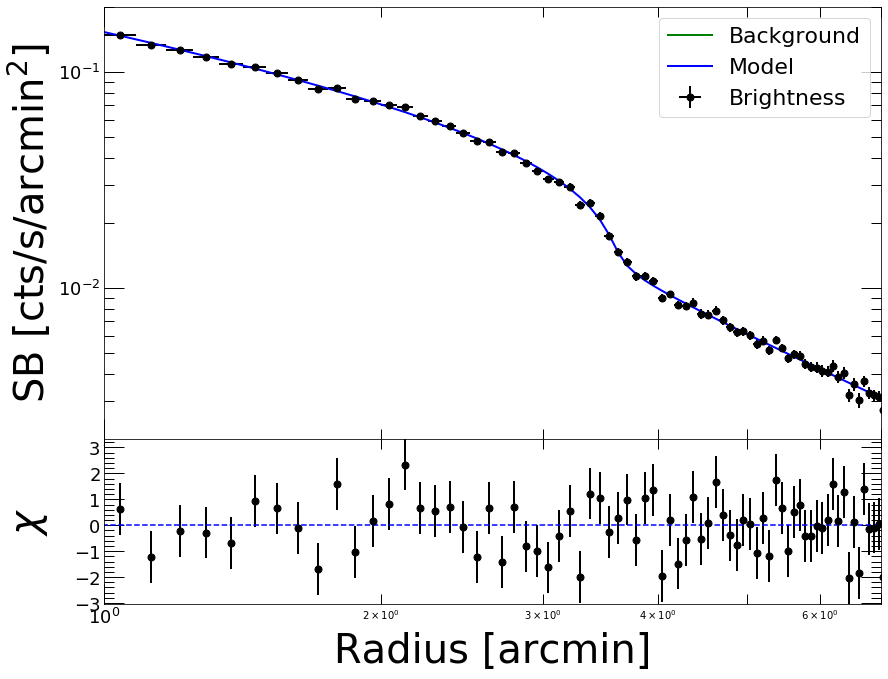

In [17]:
prof.Plot(model=modbkn, axes=[1., 7., 2e-3, 0.2])

That looks very good. By default, the code will run a [chi-square](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.ChiSquared) minimization; if instead we wish to minimize the [C statistic](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Cstat), we can run the minimization again using the _method='cstat'_ option. 

We can also fix the _bkg_ parameter since it is not very relevant in this region and its value is not well constrained

In [18]:
fitobj = pyproffit.Fitter(model=modbkn, profile=prof, method='cstat', 
                          alpha1=0.9, alpha2=1.5, rf=3.609, jump=1.92, 
                          norm=-1.9, bkg=-3.8, 
                          fitlow=1.0, fithigh=7.0)

fitobj.minuit.fixed['bkg'] = True

fitobj.Migrad()


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 81.15                      │              Nfcn = 192              │
│ EDM = 6.08e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼───

<Figure size 432x288 with 0 Axes>

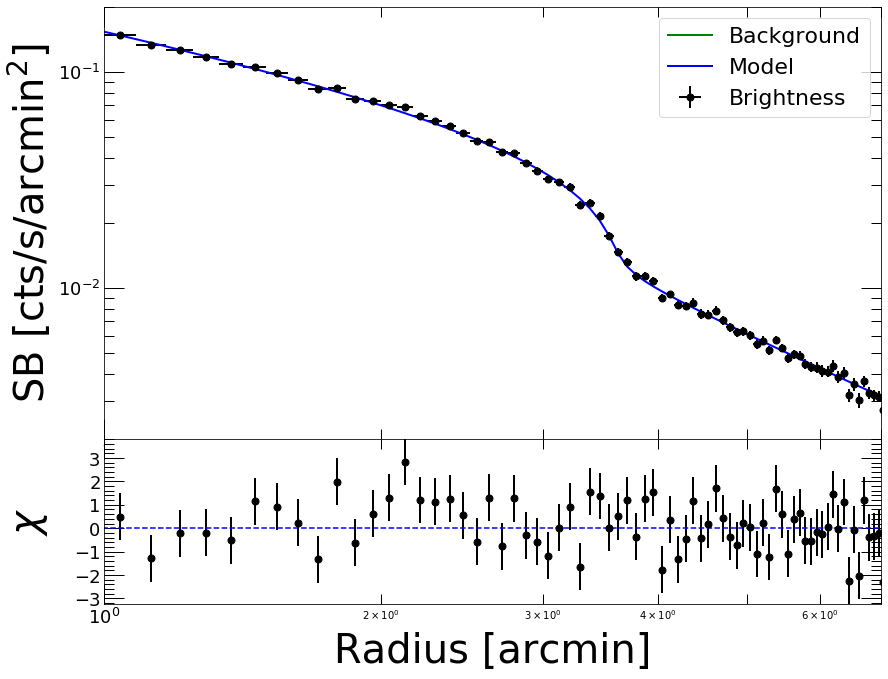

In [19]:
prof.Plot(model=modbkn, axes=[1., 7., 2e-3, 0.2])

The results obtained with the two likelihood functions are nicely consistent. In case of low quality data, however, the results obtained with C-statistic should be preferred.

## Results and uncertainties ##

The results of the fitting procedure are stored in the _params_ and _errors_ attributes of the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) object, which can be displayed using the _out_ attribute

In [20]:
fitobj.out

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 81.15                      │              Nfcn = 192              │
│ EDM = 6.08e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha1 │   0.884   │   0.012   │            │            │         │         │       │
│ 1 │ alpha2 │   1.503   │   0.025   │            │            │         │         │       │
│ 2 │ rf     │   3.615   │   0.023   │            │            │         │         │       │
│ 3 │ norm   │  -1.959   │   0.011   │            │            │         │         │       │
│ 4 │ jump   │   1.90    │   0.04    │            │            │         │         │       │
│ 5 │ bkg    │   -3.80   │   -0.04   │            │            │         │         │  yes  │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │    alpha1    alpha2        rf      norm      jump       bkg │
├────────┼─────────────────────────────────────────────────────────────┤
│ alpha1 │  0.000151 -1.66e-05  0.000162 -0.000115 -9.97e-05         0 │
│ alpha2 │ -1.66e-05  0.000627 -0.000205  5.61e-05 -0.000808         0 │
│     rf │  0.000162 -0.000205  0.000541 -0.000228  0.000226         0 │
│   norm │ -0.000115  5.61e-05 -0.000228  0.000121  6.07e-06         0 │
│   jump │ -9.97e-05 -0.000808  0.000226  6.07e-06   0.00126         0 │
│    bkg │         0         0         0         0         0         0 │
└────────┴─────────────────────────────────────────────────────────────┘

In [21]:
fitobj.params['jump']

1.901961720701023

The _Migrad_ function of [iminuit](https://iminuit.readthedocs.io) is a very efficient optimization algorithm, however it is not designed to determine accurate, asymmetric error bars. For this purpose, iminuit includes the _Minos_ algorithm, which can be ran easily from _PyProffit_

In [22]:
minos_result = fitobj.minuit.minos()

The uncertainties in the _jump_ parameter can be viewed and accessed in the following way

In [23]:
minos_result.params


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,alpha1,0.884,0.012,-0.012,0.012,,,
1,alpha2,1.503,0.025,-0.025,0.025,,,
2,rf,3.615,0.023,-0.022,0.014,,,
3,norm,-1.959,0.011,-0.011,0.010,,,
4,jump,1.902,0.036,-0.035,0.036,,,
5,bkg,-3.80,-0.04,,,,,yes


In [24]:
minos_result.merrors['jump']

┌──────────┬───────────────────────┐
│          │         jump          │
├──────────┼───────────┬───────────┤
│  Error   │  -0.035   │   0.036   │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘

In [25]:
print('Best fitting compression factor : %g (%g , %g)' 
      % (fitobj.params['jump'], minos_result.merrors['jump'].lower, minos_result.merrors['jump'].upper))

Best fitting compression factor : 1.90196 (-0.0351364 , 0.0360152)


Correlations between parameters can be investigated using the <i>draw_mncontour</i> method. Here we show the usual correlation between the outer slope of the profile $\alpha_2$ and the compression factor

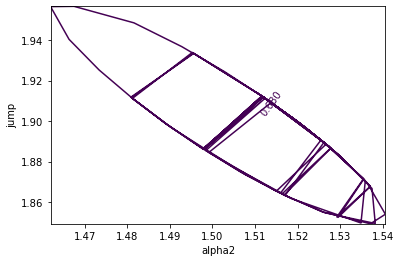

In [26]:
fitobj.minuit.draw_mncontour('alpha2', 'jump')

## Running Monte Carlo Markov Chain ##

To check the results and inspect the correlations further, we can now run a Monte Carlo Markov Chain (MCMC) using the affine invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/) assuming the corresponding package is installed. This can be done easily using the [Emcee](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter.Emcee) method of the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) class. 

If a pre-existing maximum-likelihood fit can be found, as in the previous case, the code will start from the best-fit values and automatically assign a broad Gaussian prior on each of the parameters. Alternatively, any custom prior function computing the prior probability of an input parameter set can be passed to the code via the _prior=function_ option.

100%|██████████| 1000/1000 [01:23<00:00, 11.94it/s]


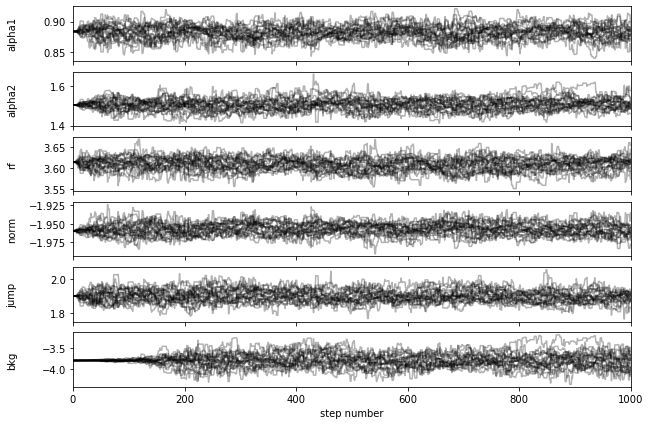

In [27]:
fitobj.Emcee(nmcmc=1000, walkers=20, burnin=200)

We can see that all the chains are well converged after step 200.

We can inspect the output chain and create a two-dimensional corner plot using the [Corner](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter.Corner) method if the [corner](https://corner.readthedocs.io/en/latest/) library is installed. All the available arguments of the corner library can be passed directly to the code as shown in the example below

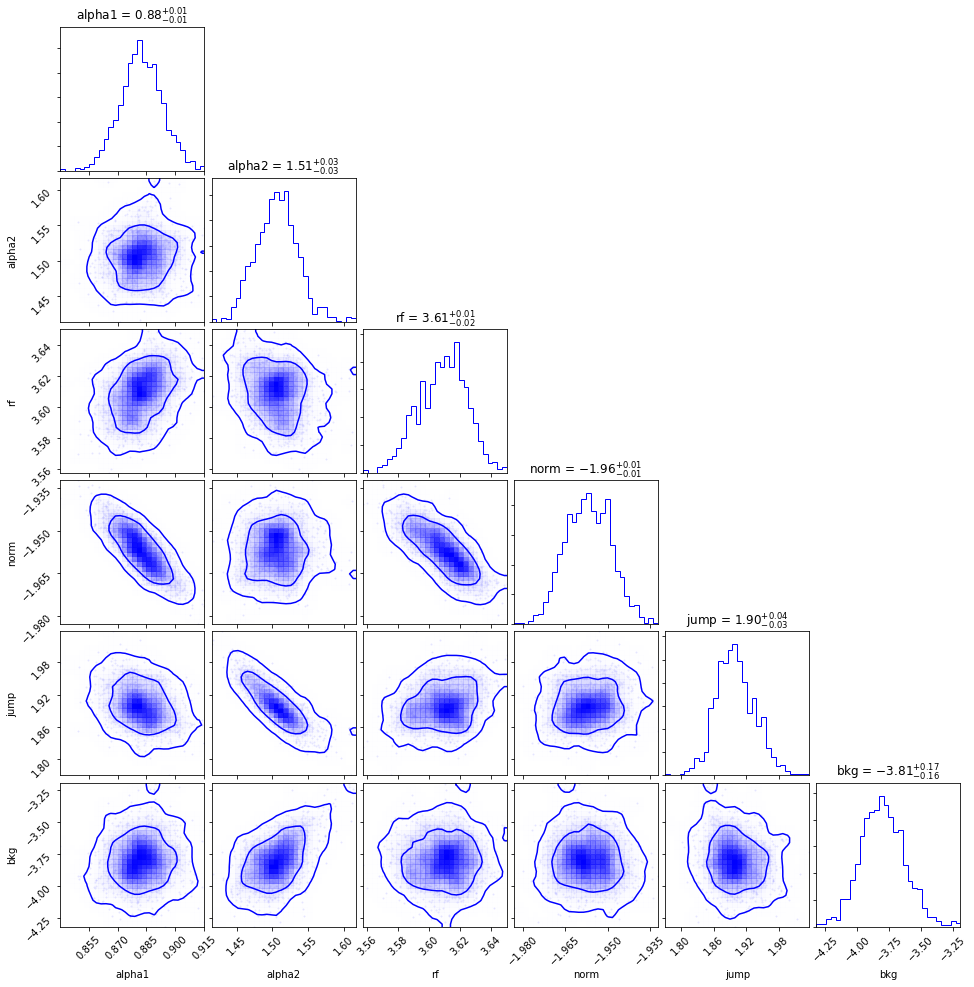

In [28]:
fig_corner = fitobj.Corner(show_titles=True, levels=(0.68, 0.95), bins=(30), no_fill_contours=True, color='blue', smooth=1.2)

Again, we can see the clear anti-correlation between the density jump and the outer slope. The uncertainties in the jump parameter are consistent with the _Minos_ results shown above. The chain can be accessed via the _samples_ attribute of the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) class, e.g. to check the individual posterior probability distributions

In [29]:
chain_jump = fitobj.samples[:,4]

median_jump, jump_lo, jump_hi = np.percentile(chain_jump, [50., 50.-68.3/2., 50.+68.3/2.])

print('Best fitting compression factor : %g (%g , %g)' 
      % (median_jump, median_jump-jump_lo, jump_hi-median_jump))

Best fitting compression factor : 1.8983 (0.0327633 , 0.0401024)


We can then look at the fitted model envelope and compare it with the data by passing the output Emcee samples to the [Plot](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile.Plot) method of the [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) class,

<Figure size 432x288 with 0 Axes>

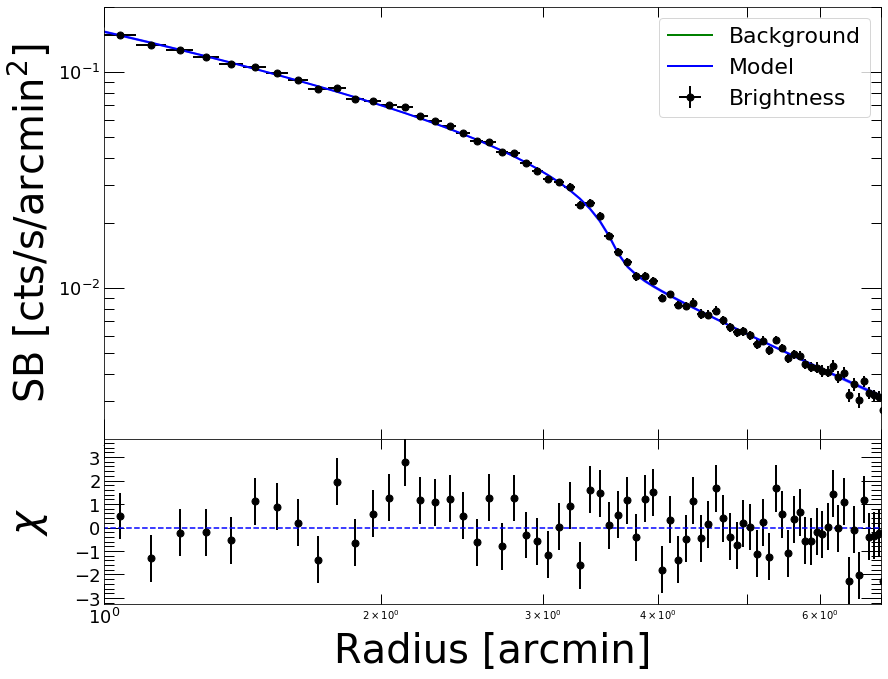

In [30]:
prof.Plot(model=modbkn, samples=fitobj.samples, axes=[1., 7., 2e-3, 0.2])